# 500px Machine Learning Engineer Intern - Tech Challenge
## Fooling an MNIST Classifier with Adversarial Images, using TensorFlow

## Description

Create adversarial images to fool a MNIST classifier in TensorFlow.

Deep convolutional neural networks (CNN) are state of the art models for image classification and object detection. Such models play crucial role at 500px where we use them for many applications like automatic keywording, people detection and image search. It’s important to understand how they work and what their limitations are.
One known “limitation” of CNN is that they can be fooled to misclassify an image with high confidence by slightly
perturbing the pixels. 

This is illustrated on the image below:

![](https://lh4.googleusercontent.com/Bz7CFzzMBRkKJ4xGqMTpufuL35Lf69z3DEoDAV-ZzD1OC9lMHYL4co0ED-LF2URMowvbDdqkRg6oxZHWeIspOVDkeaB0rqAfNpRHXfrhxS45U2cqsuX52J2GZwlFOB0TSc_rYxu7)

The delta between the original image and the adversarial one is so small that it is impossible for humans to detect. The fun fact is other machine learning models like SVM and logistic regression can be tricked in the similar manner.

Note that the “fast gradient sign” method presented in the [original paper by Goodfellow](https://arxiv.org/abs/1412.6572) produces adversarial images for a random target class. In this challenge we would like to generate adversarial images to misclassify any examples of ‘2’ as ‘6’ specifically. This puts certain implications on the final solution.

One of the useful application for adversarial images is that if you train your deep CNN classifier on them you can improve its accuracy on non-adversarial examples.

In this challenge you are given an opportunity to learn how to generate adversarial examples and also gain practical experience using Tensorflow.

### Getting Started

Let's start by importing dependencies, and loading up the MNIST dataset. Note that much of the code in this section, and sections to come, is repurposed from [this tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/#deep-mnist-for-experts).

Also, let's write functions to save and load a trained model, since we'll be doing quite a bit of that and it'll spare us from having to re-train all the time. We also need plotting functions; a function that visualizes heatmaps, since we'll be doing quite a bit of that as well (note that the plotHeatmap function is modified from a project I'd previously completed, the code can be found [here](https://github.com/MunirAD/Facial_Recognition_AlexNet/blob/master/part3.py), and a function that plots the images in a matrix (this will be used to get the 3 x 10 desired output).


In [114]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import cPickle as pickle 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

sess = tf.InteractiveSession()
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

def save_model(model, filename):
    if os.path.exists(filename):
        print("The file '" + filename + "' already exists in the cwd")
        return
    with open(filename, 'w') as fp:
        pickle.dump(model, fp)
    
def load_model(filename):
    if not os.path.exists(filename):
        print("The file '" + filename + "' does not exist in the cwd")
        return
    with open(filename, 'r') as fp:
        model = pickle.load(fp)
    return model

def plotHeatmap(x, size):
    fig = plt.figure()
    ax = fig.gca()
    gray_scale_img = x.reshape((size, size))
    heatmap = ax.imshow(gray_scale_img, cmap = mpl.cm.coolwarm)
    fig.colorbar(heatmap, shrink = 0.5, aspect=5)
    plt.show()

def plotImages(matrix):
    num_rows = len(matrix)
    num_cols = len(matrix[0])
    fig = plt.figure()
    idx = 1
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            plt.subplot(num_rows, num_cols, idx)
            idx += 1
            plt.imshow(matrix[i][j].reshape((28,28)), cmap="gray")
            plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x13fde9590>> ignored


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Vanilla Neural Network 

Now that we have the data, let's get our feet wet with TensorFlow by implementing a basic fully connected neural network with one hidden layer, and see how it performs on the data. Note that aside from using the TensorFlow code mentioned earlier, much of this code is repurposed from an earlier project I've completed, which can be found [here](https://github.com/MunirAD/Facial_Recognition_AlexNet/blob/master/part2.py) (in the `fully_connected` function code).



In [22]:
def FullyConnectedNet(num_in, num_hid, num_out, lam, learn_rate, num_epochs, batch_size):
    
    # Set up a placeholder for the input 'x' and its label 'y_' 
    # Note the label is in one-of-k (one-hot) encoding
    x = tf.placeholder(tf.float32, [None, num_in])
    y_ = tf.placeholder(tf.float32, [None, num_out])

    # Set up variables for the network parameters. Note this is a single-hidden
    # layer network
    W0 = tf.Variable(tf.random_normal([num_in, num_hid], stddev=0.01))
    b0 = tf.Variable(tf.random_normal([num_hid], stddev=0.01))
    W1 = tf.Variable(tf.random_normal([num_hid, num_out], stddev=0.01))
    b1 = tf.Variable(tf.random_normal([num_out], stddev=0.01))
    
    # Initialize the variables
    sess.run(tf.initialize_all_variables())
    
    # Set up the computation of a forward pass on an input to the net
    layer1 = tf.nn.relu(tf.matmul(x, W0) + b0)
    layer2 = tf.matmul(layer1, W1) + b1
    y = tf.nn.softmax(layer2)
    
    # Set up a decay penalty to regularize, reducing the risk of over-fitting
    decay_penalty = lam*tf.reduce_sum(tf.square(W0)) + lam*tf.reduce_sum(tf.square(W1))
    NLL = -tf.reduce_sum(y_*tf.log(y)) + decay_penalty
    
    # Set up the Gradient Descent optimization step on the objective function 
    # with the given learning rate
    train_step = tf.train.GradientDescentOptimizer(learn_rate).minimize(NLL)
    
    # Set up the logic for what a correct prediction is, and 
    # classification accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Do mini batch gradient descent
    for i in range(num_epochs):
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict = {x: batch[0], y_ : batch[1]})
    
    # Print the accuracy on the validation data
    print "Accuracy on the validation set is: ",
    print(accuracy.eval(feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))

FullyConnectedNet(784, 300, 10, 0.01, 0.0005, 1000, 100)

Accuracy on the validation set is:  0.9118


The accuracy on the validation set with the given hyperparameters for the above model, is approximately 91%. Now we can move on to a more interesting model

### Convolutional Neural Network

For the sake of simplicity, since the target for this project isn't to play around with Convolutional network architectures, let's stick with the architecture specified in the [TensorFlow tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/#deep-mnist-for-experts).

The architecture specified by the tutorial is 

1) **CONV LAYER 1** 

Convolve on the input with 32 weight matrices, each in $\mathbb{R}^{5\times5}$. This results in an output volume with depth 32, the width and height of the output volume is $p$ where $p = \frac{N-F}{S} + 1$, where $N$ is the width (& height) of the input image, $F$ is the width (& height) of the weights matrix, $S$ is the stride with which we convolve (how much we slide along the input image with each dot product). 

We know that $N$ is 28 (since we know that the MNIST images are in $\mathbb{R}^{28\times28}$), but it's mentioned in the tutorial that, for this architecture, we want the output of the conv layer to have the same dimensionality as the input in terms of width and length (so as not to lose information early in the model), this is achieved by padding it with 0's. To preserve the input spatially, the amount of zero-padding has to be $\frac{F-1}{2}$, since $F = 5$, then we have to add 2 extra rows of zero's, and 2 extra columns of 0's, making $N = 32$. With that, and the fact that, $F = 5$, $S = 1$, the output volume is in $\mathbb{R}^{28\times28\times32}$

2) **MAX POOLING 1** 

Max pool on the output volume of the first conv layer, over $2\times2$ blocks

3) **CONV LAYER 2**

WLOG, this conv layer functions in the same way as the first one, except that its input is the output of the first max pooling layer, and here we have 64 weights matrices (instead of 32)

4) **MAX POOLING 2**

WLOG, this pooling layer in the exact same way as the first pooling layer, except that its input is the output of the second conv layer.

5) **Fully Connected Network**

The output of the second max pooling layer can be thought of a highly-level feature map representing the input image, we need a fully connected network to take as input this feature map, and predict the class. The width and height of the feature map is in $\mathbb{R}^{7\times7}$ (as a result of the maxpooling) with depth (as a result of the second convolutional layer), thus the input to the fully connected network is in $\mathbb{R}^{7\times7\times64}$. 

To feed it to a fully connected net, we flatten it to $\mathbb{R}^{3136}$. There's one hidden layer with 784 units (note that in the tutorial, its actually 1024 units, I've changed it [in retrospect: the reason I changed it was because I thought I'd be adding the gradient of the output with respect to this layer to the input (thereby requiring it to have the same dimensionality as the input), upon completing this project I've realized this was completely unnecessary]), and each hidden unit has its own bias term. So the parameters are $\textbf{W}_0 \in \mathbb{R}^{3136\times784}$ and $\vec{b_0} \in \mathbb{R}^{784}$. A ReLU activation is applied at this layer, therefore the values of the hidden neurons are given by 
$$\vec{h} = ReLU(\textbf{W}_0^{\text{T}}\vec{x} + \vec{b})$$
Where $\vec{x}$ is the flattened output of the second max pooling layer.

The architecture specified in the tutorial uses [dropout](https://www.youtube.com/watch?v=kAwF--GJ-ek&spfreload=10) at this point to minimize overfitting. I will use the same thing.

Then we go to the output layer, which has 10 output units (1 for each class), therefore our parameters are $\textbf{W}_1 \in \mathbb{R}^{784\times10}$ and $\vec{b} \in \mathbb{R}^{10}$, so we get that the values of the output neurons are given by 
$$\vec{o} = \textbf{W}_1^{\text{T}}\vec{h} + \vec{b_1}$$

Finally, softmax is applied to $\vec{o}$:
$$\forall i \in enumerate(\vec{o}), o[i] = \frac{\exp({{\vec{o}[i]}})}{\sum_{j \in o}\exp({\vec{o}[j]})}$$

Which gives us, 
$$P(y^{(k)} = i | \textbf{x}^{(k)}) = \vec{o}[i]$$

Now that we're familiar with the architecture, let's copy the code (verbatim - with some comments added to know what's happening)

*Step 1*: Two helper functions are defined to generate tensorFlow weight and bias variables.

In [23]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

*Step 2*: Two helper functions are defined to do the convolution operation and the pooling operation

In [24]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

*Step 3*: Set up the pre fully connected net computations

In [25]:
# Set up placeholders for x and y_
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Shape the image so that it matches with the parameters
x_image = tf.reshape(x, [-1,28,28,1])

# Set up the parameters & computation for the first convolutional + pooling layers
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Set up the parameters & computation for the second convolutional + pooling layers
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

*Step 4*: Set up the fully connected net computations 

In [26]:
# Set up the computation & parameters for the hidden layer
W_fc1 = weight_variable([7 * 7 * 64, 784])
b_fc1 = bias_variable([784])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Do dropout on the hidden layer
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Set up the computation & parameters for the output layer
W_fc2 = weight_variable([784, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

*Step 5*: Train the network

In [27]:
# Set up the loss function we're minimizing
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))

# Set up the optimizer method, note that the Adam update rule is being used instead of
# basic Gradient Descent
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Set up the rules for correct prediction and classifiaction accuracy, 
# and initialize the session variables
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

# Check if we already have a trained model, train only if 
# there isn't a model in the cwd
if not load_model('convolutional_model.pkl'):
    # Do mini-batch gradient descent with stdout updates every 
    # 100 epochs
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    # Print the test accuracy
    print("test accuracy %g"%accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    # Save the trained model parameters
    model = {'W_conv1' : sess.run(W_conv1), 'b_conv1' : sess.run(b_conv1),
            'W_conv2' : sess.run(W_conv2),'b_conv2' : sess.run(b_conv2),
            'W_fc1' : sess.run(W_fc1), 'b_fc1' : sess.run(b_fc1),
            'W_fc2' : sess.run(W_fc2), 'b_fc2' : sess.run(b_fc2)}

    save_model(model, 'convolutional_model.pkl')


The conv net at this point is trained, (note that in the tutorial it was trained with 20,000 epochs, I only trained it for 1000 due to time constraints). Let's set up a function to do a forward pass on an input image and predict its label.

In [171]:
def conv_predict(inp, file_with_model):
    # Load the pre-trained model data
    model = load_model(file_with_model)
    
    # Fix the input shape to match the net input
    shaped_input = np.reshape(inp,(1, 784))    
    
    # Set up placeholder for x
    x = tf.placeholder(tf.float32, shape=[None, 784])
        
    # Shape the image so that it matches with the parameters
    x_image = tf.reshape(x, [-1,28,28,1])

    # Load up the parameters & set up computation for the first convolutional + pooling layers
    W_conv1 = model['W_conv1']
    b_conv1 = model['b_conv1']
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # Load up the parameters & set up computation for the second convolutional + pooling layers
    W_conv2 = model['W_conv2']
    b_conv2 = model['b_conv2']
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # Load up the parameters & set up computation for the hidden layer of the fully connected ned
    W_fc1 = model['W_fc1']
    b_fc1 = model['b_fc1']
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Do dropout on the hidden layer
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Load up the parameters & set up computation for the output layer
    W_fc2 = model['W_fc2']
    b_fc2 = model['b_fc2']
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    y = tf.nn.softmax(y_conv)
    
    # Initialize all the all the variables and run the session
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    
    # Get the softmax probability vector and return its argmax
    prob = sess.run(y, feed_dict={x: shaped_input, keep_prob: 1.0})
    return np.argmax(prob)

## Getting started with adversarial images 
So far, we have a trained and ready to go fully-connected network, and a convolutional network. But we haven't generated any adversarial examples or gained any intuition as to how it works. Before diving into generating adversarial examples with the convolutional network, let's set up an extremely simple network, generate adversarial examples with it, and try to gain some intuition.

The BasicNet will just be 784 input units that connect directly to 10 output units, where softmax is applied. 

In [169]:
def BasicNet():
    # Set up placeholders for x and y_
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Shape the image so that it matches with the parameters
    x_image = tf.reshape(x, [-1,28,28,1])

    # Set up the parameters & computation for the first (and only) layer
    W = tf.Variable(tf.random_normal([784, 10], stddev=0.01))
    b = tf.Variable(tf.random_normal([10], stddev=0.01))
    o = tf.nn.relu(tf.matmul(x, W) + b)
    y = tf.nn.softmax(o)

    # Set up the loss function we're minimizing
    NLL = -tf.reduce_sum(y_*tf.log(y))

    # Set up the optimizer method
    train_step = tf.train.GradientDescentOptimizer(0.001).minimize(NLL)

    # Set up the logic for what a correct prediction is, and
    # classification accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Initialize the session variables
    sess.run(tf.initialize_all_variables())

    # Do mini batch gradient descent
    for i in range(5000):
        batch = mnist.train.next_batch(100)
        train_step.run(feed_dict = {x: batch[0], y_ : batch[1]})

    # Print the accuracy on the validation data
    print 'The accuracy on the validation set is: ',
    print(accuracy.eval(feed_dict={x: mnist.validation.images, y_: mnist.validation.labels}))
    
    # Save the model
    model = {'W' : sess.run(W), 'b' : sess.run(b)}
    save_model(model, 'basic_model.pkl')

# If there isn't a trained model, train one
if not load_model('basic_model.pkl'):
    BasicNet()

In the above network, we take an input $\vec{x} \in \mathbb{R}^{784\times1}$, we have parameters $\textbf{W}\in\mathbb{R}^{784\times10}$ and $\vec{b} \in \mathbb{R}^{10\times1}$. The output is simply
$$\vec{o} = ReLU(\textbf{W}^{\text{T}}\vec{x} + \vec{b})$$

And softmax is applied to $\vec{o}$, yielding $\vec{s}$. The cost function is just the negative log likelihood.

Knowing all this, let's pivot towards adversarial examples. From [Karpathy's blog post](http://karpathy.github.io/2015/03/30/breaking-convnets/), we know that 

> To create a fooling image we start from whatever image we want (an actual image, or even a noise pattern), and then use backpropagation to compute the gradient of the image pixels on any class score, and nudge it along

Mathematically, we combine this concept with the equation from [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) to get:
$$\vec{x} = \vec{x} + \eta \text{ sign}(\nabla_{\vec{x}}(s_i))$$

Where $s_i$ is the likelihood of observing class $i$ given $\vec{x}$ 
Perturbing $\vec{x}$ in this way fools the network into thinking that $\vec{x}$ is of class $i$.

Before we dive into the code, we need $\nabla_{\vec{x}}(s_i)$

First, we recognize that the following must hold:

$$\nabla_{\vec{x}}(s_i) = \frac{\partial s_i}{\partial o_i} * \frac{\partial o_i}{\partial \vec{x}}$$

Then we solve for each component, 
$$\frac{\partial s_i}{\partial o_i} = (s_i)(1-s_i)$$
and, 
$$\frac{\partial o_i}{\partial \vec{x}} = \textbf{W}_{:, i}$$

Now we have what we need to write the code

In [122]:
def adversarial(inp, faker_class, plot_heatmaps=False):
    # Load the pre-trained model
    model = load_model('basic_model.pkl')
    
    # Shape the input to match
    this_x = np.reshape(inp,(1, 784))

    # Setup the placeholder
    x = tf.placeholder(tf.float32, shape=[None, 784])
    
    # Reshape the image
    x_image = tf.reshape(x, [-1,28,28,1])

    # Load the parameters & set computation for the network
    W = model['W']
    b = model['b']
    o = tf.nn.relu(tf.matmul(x, W) + b)
    y = tf.nn.softmax(o)

    # Initialize the variables and run the session to find the softmax (p)
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)
    p = sess.run(y, feed_dict={x: this_x})
    
    # Reshape the softmax 
    p = np.reshape(p, (10,1))
    
    # Up to this point, we've computed the softmax but we haven't perturbed the input, 
    # we need the softmax of the class we want to fake (faker_class) in order to perturb
    # now that we have it, we can do a forward pass
    def forwardpass(eta):
        # Get the perturbation value 
        eta_times_grad = eta*np.sign((W[:,faker_class] * (p[faker_class]*(1-p[faker_class]))))

        # Perturb the input
        new_this_x = this_x + eta_times_grad
        
        # Setup the network again
        new_x = tf.placeholder(tf.float32, shape=[None, 784])
        new_o = tf.nn.relu(tf.matmul(new_x, W) + b)
        new_y = tf.nn.softmax(new_o)
    
        # Check if we want to plot the heatmaps
        if (plot_heatmaps):
            print("Input pre-perturbation")
            plotHeatmap(this_x, 28)
            print("Perturbation")
            plotHeatmap(eta_times_grad, 28)
            print("Input post-perturbation")
            plotHeatmap(new_this_x, 28)
        
        # Initialize the variables and get the softmax
        new_init = tf.initialize_all_variables()
        new_sess = tf.Session()
        new_sess.run(init)
        new_p = new_sess.run(new_y, feed_dict={new_x: new_this_x})
        
        # Return the argmax of the softmax
        return (np.argmax(new_p), this_x, eta_times_grad, new_this_x)
    
    # Call forwardpass with the perturbation scaling factor
    return (np.argmax(p), forwardpass(0.2))

The decision to make $\eta = 0.2$ was based off the fact that in [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf), $\eta = 0.25$ in the MNIST example (page 4 figure 2 description). I've reduced it slightly because I wanted to decrease the perturbation as much as possible while still having network predict incorrectly. Now that this is implemented, let's sanity check it with one example: 

True class: 7
Originally predicted class: 7
Predicted class after perturbation: 3
Expected class: 3


<IPython.core.display.Javascript object>


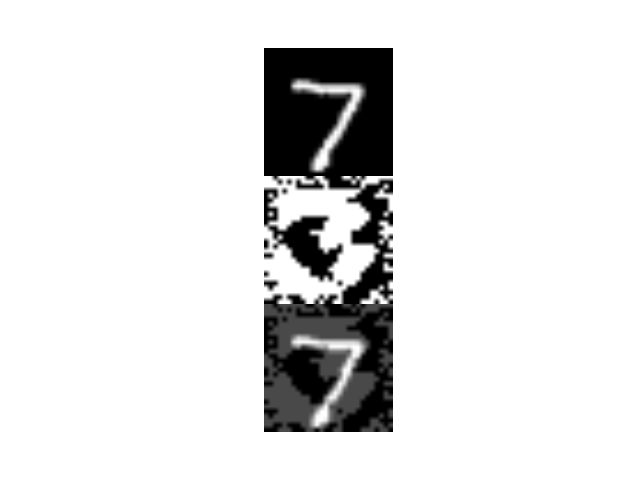

In [125]:
def example(fake_class):
    original_prediction, (faked_prediction, pre, delt, post) = adversarial(mnist.test.images[0], fake_class)
    print "True class: " + str(np.argmax(mnist.test.labels[0]))
    print "Originally predicted class: " + str(original_prediction)
    print "Predicted class after perturbation: " + str(faked_prediction)
    print "Expected class: " + str(fake_class)

    plotImages([[pre], [delt], [post]])
    
example(3)

Before we go into any sort of analysis to figure out why this works, let's first complete the challenge for this particular network. That is, find 10 examples of 2's that are correctly classified originally, but after perturbing them, they are predicted to be 6's, proceed to plot these 10 with their pre-delta features, delta features, and post-delta features.

<IPython.core.display.Javascript object>


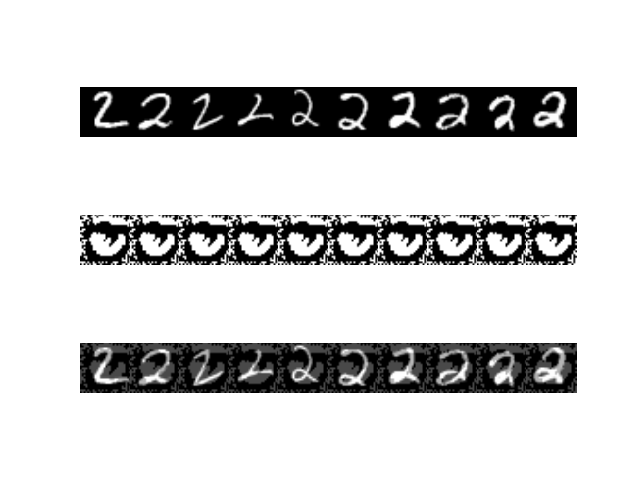

In [288]:
def findExamples(target_class, misclassify_as, num_examples, func):
    # Find the indexes in the test set of all images with class == target_class
    idxs_of_target = filter(lambda i: np.argmax(mnist.test.labels[i]) == target_class, range(len(mnist.test.images)))
    
    # Find num_examples examples that satisfy the conditions that
    #        1) Predicted as target_class originally 
    #        2) Predicted as misclassify_as when perturbed
    
    # Keep track of all the pre-delta, delta, and post-delta vectors
    pres, delts, posts = [], [], []
    i = 0
    num_found = 0
    while(num_found != num_examples):
        cur_idx = idxs_of_target[i]
        original_y, (faked_y, pre, delt, post) = func(mnist.test.images[cur_idx], misclassify_as)
        if original_y == target_class and faked_y == misclassify_as:
            num_found += 1
            pres.append(pre)
            delts.append(delt)
            posts.append(post)
        i += 1
    
    return [pres, delts, posts]
            
    
matrix = findExamples(2, 6, 10, adversarial)
plotImages(matrix)
            

Ok, this is fairly interesting. The first thing we notice is that the delta's all look to be pretty much the same. Let's confirm whether or not they are all the same, and continue with some analysis.


In [166]:
equals = []
for i in range(1, 10):
    equals.append((matrix[1][i-1] == matrix[1][i]).all())
if False in equals:
    print "Not all deltas are equal"
else:
    print "All deltas are equal"

All deltas are equal


It turns out that in fact, all the deltas are equal. Let's look more closely into this, consider back in the code how the delta's were computed:

> `eta_times_grad = eta*np.sign((W[:,faker_class] * (p[faker_class]*(1-p[faker_class]))))`

We know that $\eta$ is constant over all examples, as is $\textbf{W}_{:, i}$ where $i$ is the `faker_class`. However, $p[i] * (1-p[i])$ is not necessarily equal over all examples. Recall that $p[i]$ is the probability that the input belongs to class $i$, so it's entirely possible (in fact, it's extremely likely) that all inputs have different values for $p[i]$. However, for every case, and for every possible $i$, it's necessarily true that $p[i] > 0$ (technically its that $p[i] >= 0$ but the case where $p[i] = 0$ occurs is far less often); this is since softmax generates a valid probability distribution, i.e., all values sum to 1 and are between 0 and 1 (inclusive). Since this is the case, then it's (almost) always true that $(1 - p[i]) > 0$. Thus, having that $p[i] > 0$ and $(1-p[i]) > 0$ in the majority of cases means that $p[i] * (1-p[i]) > 0$.

Given the results above, this tells us that multiplying $\textbf{W}_{:, i}$ by $p[i] * (1-p[i])$ will (almost) never change the direction of the weights [caveat: the reason i say *almost* is because there are rare cases where $p[i] * (1-p[i]) = 0$, thereby causing an absorbtion by 0]. Therefore, taking the `np.sign` of that multiplication will yield the same result almost all the time. And since $\eta$ doesn't change for any of the cases, multiplying it by the result of `np.sign` will never yield a different delta between cases.

Now that we know why the deltas are always equal, lets try to gain some intuition as to why superimposing the delta on the input works in making the network falsely predict the label.

The 'image' that gets imposed, is effectively the weights connecting the input layer to the output unit corresponding to the class we want our network to be tricked into believing is the correct class (in the case above, this is 6). The rest of the values only scale the effect of this. Since these are greyscale images, the scaling factors affect the pixel intensities of that same image. Let's look more closely at that image alone, with no scaling factors

<IPython.core.display.Javascript object>


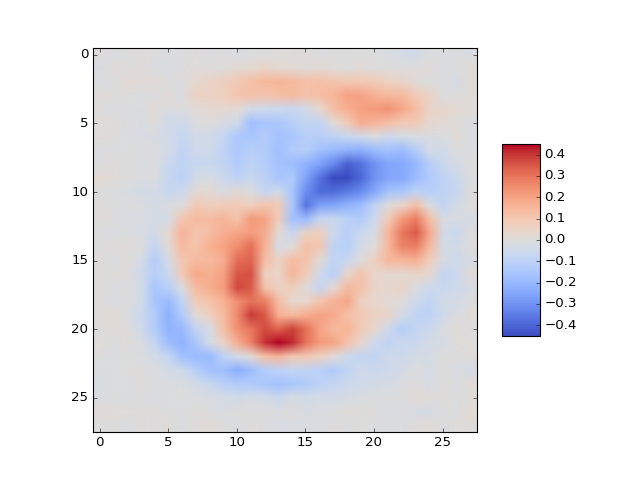

In [163]:
fake_class = 6
image = load_model('basic_model.pkl')['W'][:,fake_class]
plotHeatmap(image, 28)

The image appears to be a 'template' of a 6. In fact, if we plot the heatmap of any of the set of weights connected to individual output units, we'll find that the weights connected to the ith output unit will be a template for the ith class. The whole point behind deep networks is that the deeper we go into the network, the more **higher level** features that we extract. That is, the features that most affect the construction of the decision boundaries between different classes [caveat: 'deep' within reason. For input images that are not complex, a good example of this is MNIST, extremely deep networks may be counterproductive since the information gain given the class may not increase (in fact, the overall entropy of the class may increase). How deep a network should be is determined mostly by the complexity of its inputs, images in $\mathbb{R}^{227\times227\times3}$ would require deeper architectures such as [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)].

Relating this back to the delta used to perturb the input, effectively we're superimposing on the input the features which are most similar to the template of a 6 that the network has trained. The higher the scaling coefficient of the superimposed image, (a) the more that the perturbed image looks like the template thereby causing (b) a higher likelihood of predicting the class of the imposed image.

In fact, we can see this effect by viewing the likeness of the heatmap of one of the deltas to the superimposed image.


<IPython.core.display.Javascript object>


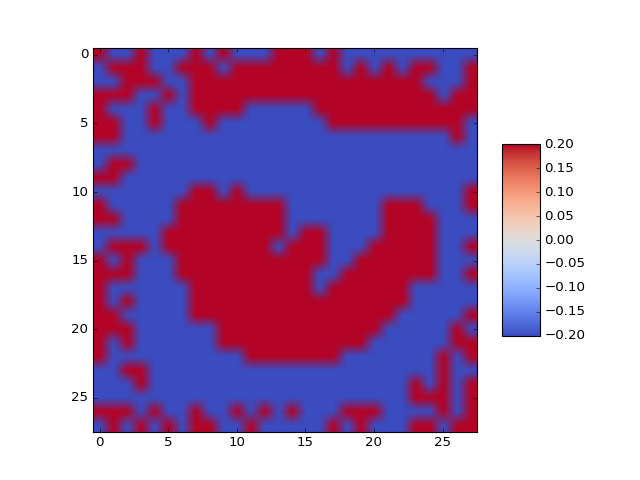

In [170]:
plotHeatmap(matrix[1][0], 28)

## Adversarial images with the Convolutional Network
Now that we have some intuition behind adversarial images and how they work, let's move on to generating them such that they trick the convolutional network. Let's start by rewriting the conv `conv_predict` function in the likeness of `adversarial` 

In [284]:
def convolutional_adversarial(inp, faker_class):
    model = load_model('convolutional_model.pkl')
    
    # Fix the input shape to match the net input
    shaped_input = np.reshape(inp,(1, 784))   
    
    # Set up placeholder for x
    x = tf.placeholder(tf.float32, shape=[1, 784])
        
    # Shape the image so that it matches with the parameters
    x_image = tf.reshape(x, [-1,28,28,1])

    # Load up the parameters & set up computation for the first convolutional + pooling layers
    W_conv1 = model['W_conv1']
    b_conv1 = model['b_conv1']
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    # Load up the parameters & set up computation for the second convolutional + pooling layers
    W_conv2 = model['W_conv2']
    b_conv2 = model['b_conv2']
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    # Load up the parameters & set up computation for the hidden layer of the fully connected ned
    W_fc1 = model['W_fc1']
    b_fc1 = model['b_fc1']
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Do dropout on the hidden layer
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Load up the parameters & set up computation for the output layer
    W_fc2 = model['W_fc2']
    b_fc2 = model['b_fc2']
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    y = tf.nn.softmax(y_conv)
    y = tf.reshape(y, [10,1])
    
    # Get the gradient of the output at the class we want the net 
    # to mistakenly think is the true class w/ r.t. the shaped_input
    indices = tf.constant([faker_class])
    indexed = tf.gather(y, indices)
    gradients = tf.gradients(indexed, x)    
    
    # Set up the session & initialize the variables
    sess = tf.Session()
    sess.run(tf.initialize_all_variables())
    
    # Compute the gradients of the output w/ r.t. input
    grads = sess.run(gradients, feed_dict={x:shaped_input, keep_prob: 1.0})
    
    # Get the softmax probability vector and return its argmax
    p = sess.run(y, feed_dict={x: shaped_input, keep_prob: 1.0})
        
    # Up to this point, we've computed the softmax but we haven't perturbed the input, 
    # we need the softmax of the class we want to fake (faker_class) in order to perturb
    # now that we have it, we can do a forward pass
    def forwardpass(eta):
        # Get the perturbation value 
        eta_times_grad = eta*np.sign(grads)
        
        # Perturb the input
        new_this_x = shaped_input + eta_times_grad
        
        # Get the prediction
        prediction = conv_predict(new_this_x, 'convolutional_model.pkl')
        
        return (prediction, shaped_input, eta_times_grad, new_this_x)
    
    # Call forwardpass with the perturbation scaling factor
    return (np.argmax(p), forwardpass(0.25))
    
    

The implementation above is mostly straight forward and is just an extension of `adversarial`, however, the difference is that in `adversarial`, the gradient of the output at a certain index with respect to the class was computed numerically using the equation I derived. In the convolutional network, deriving the equation is extremely tedious, and unnecessary. [`tf.gradients(y, x)`](https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation) allows us to get the gradients directly, the only challenge is that the return of the function will sum over all $\frac{\partial y}{\partial x}$, so if it were simply called in this way: `tf.gradients(y, x)`, then it would return a single vector in $\mathbb{R}^{1\times784}$, where what we want is 10 (or more generally, the number of classes) such vectors (one for each class), so that we can get the change in a specific output unit with respect to the input. We circumvent this by using [`tf.gather`](https://www.tensorflow.org/api_docs/python/tf/gather), which would allow us to pass in a specific 'slice' of `y` (in our case, specifically the unit corresponding to the class we want the net to be tricked into predicting is the correct class) and return the sum of the gradients of the items in the slice with respect to the input. Since the slice only has one output unit in it, the sum over the gradients of the items in the slice is just the gradient of the one output unit in the slice, which is what we want.

In the same way that we did before, let's get a random example and see stuff

True class: 7
Originally predicted class: 7
Predicted class after perturbation: 3
Expected class: 3


<IPython.core.display.Javascript object>


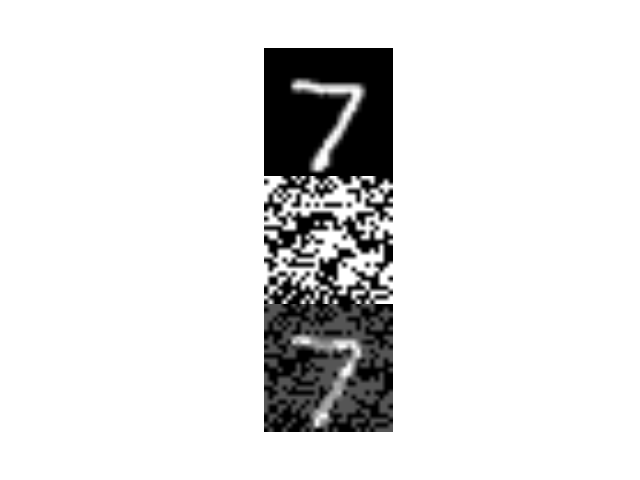

In [285]:
def example2(fake_class):
    original_prediction, (faked_prediction, pre, delt, post) = convolutional_adversarial(mnist.test.images[0], fake_class)
    print "True class: " + str(np.argmax(mnist.test.labels[0]))
    print "Originally predicted class: " + str(original_prediction)
    print "Predicted class after perturbation: " + str(faked_prediction)
    print "Expected class: " + str(fake_class)

    plotImages([[pre], [delt], [post]])
    
example2(3)

Now let's generate the 3 x 10 image from before, using this adversarial function

<IPython.core.display.Javascript object>


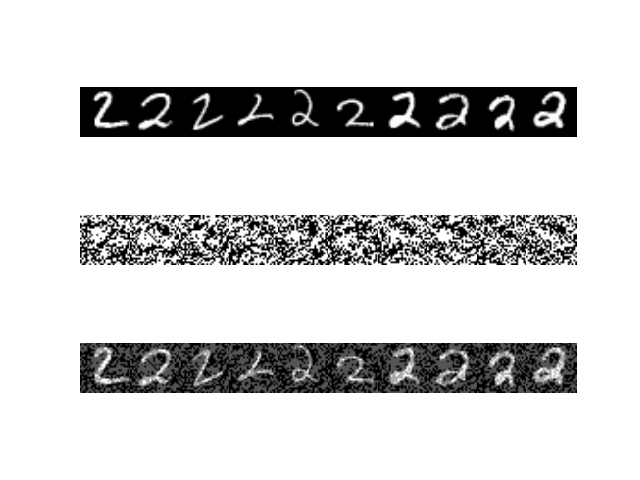

In [289]:
matrix = findExamples(2, 6, 10, convolutional_adversarial)
plotImages(matrix)

In [296]:
# Check how many of the deltas are equal (if any)
equals = []
for i in range(1, 10):
    equals.append((matrix[1][i-1] == matrix[1][i]).all())
if False in equals:
    print "Not all deltas are equal"
    print "The number of equal deltas is: " + str(len(filter(lambda x: x, equals)))
else:
    print "All deltas are equal"

Not all deltas are equal
The number of equal deltas is: 0


In contrast with the case with the basic neural network, we can see here that none of the deltas are equal. This was to be expected, since the computation of the deltas here involves far more layers and transformations than it did with the basic net (wherein the delta was just scaled weights). While it's harder to directly interpret these deltas from just looking at them, our analysis from the basic net does extend to this case. The deltas capture high level features from which decision boundaries are generated, adding this perturbation to the input makes it fall in a subspace with a different class once transformed by the CNN. 

## Some interesting questions moving forward
1) How would the deltas change if we allow our network to fully overfit on the training data (no regularization, and training beyond to the point of increasing entropy on the validation set)

2) How can we make the net resilient against these cases? Would we - post training - convert our training data into adversarial examples and train on them again? If we do this, do we run the risk of overfitting?